In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [20]:
if torch.cuda.is_available():
    device = torch.device("cuda") # GPU를 device에 넣는다.
    print("CUDA(GPU)를 사용합니다.")
else:
    device = torch.device("cpu")
    print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


In [21]:
# myResNet 클래스 정의
class myResNet(nn.Module):
    def __init__(self):
        super(myResNet, self) .__init__()
        # ResNet18 모델 로드
        self.resnet = models.resnet18(weights=None) # torchvision의 models에 resnet18이 있다!
        # 출력 레이어를 클래스 수에 맞게 조정 -- 결과 레이블에 맞게 출력 되는 수를 맞추는 것
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 10)

    def forward(self, x):
        return self.resnet(x)

In [22]:
# CIFAR10 데이터셋 로드 및 전처리 - 비행기, 자동차, 새, 고양이, 사슴, 개, 개구리, 말, 배, 트럭 이미지 데이터 셋 - 이걸 분류할거야
# transform은 전처리 변환을 의미한다.
transform = transforms.Compose([
transforms.ToTensor(),
transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615]) # 알려진 CIFAR10의 평균과 표준편차
]) # R G B  값의 평균, 표준표차 CIFAR10, 이미지는 RGB 이미지이기에

train_dataset = datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./CIFAR10', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

Files already downloaded and verified


In [23]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myResNet().to(device) # ResNet 인스턴스를 생성하고 GPU에 올린다.
criterion = nn.CrossEntropyLoss() # 손실함수, 오차
optimizer = optim.SGD(model.parameters(), lr=0.01,momentum=0.5) # SGD 학습에 가속도를 준다. 가중치 변화를 0.5 모멘텀을 더 더해서 변화하게 하자. 끼익 하고 밀리게

In [24]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [1]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    correct = 0 # 정답 횟수
    total = 0 # 전체 개수
    for data, target in train_loader:
        if torch.cuda.is_available(): # GPU 사용이 가능하다면
            data, target = data.to(device), target.to(device) #GPU로 돌려줘
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

    # 예측값 계산 (가장 높은 값을 가진 인덱스)
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    # 올바르게 예측된 샘플의 수 업데이트
    correct += (predicted == target).sum().item()

    # 평균 훈련 손실 계산
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    print (f'Epoch {epoch}, Training loss: {train_loss:.4f}')
    accuracy = 100. * correct / total
    # train_accuracies.append(train_accuracies) # 정확도 기록을 위한 리스트에 추가
    train_accuracies.append(accuracy) # 정확도 기록을 위한 리스트에 추가

In [2]:
# 테스트 함수
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if torch.cuda.is_available():
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(accuracy)
    print(f'Test loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

In [28]:
# 훈련 및 테스트 실행
for epoch in range(1, 10):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

Epoch 1, Training loss: 1.5749
Test loss: 1.3231, Accuracy: 51.71%
Epoch 2, Training loss: 1.2127
Test loss: 1.1862, Accuracy: 57.32%
Epoch 3, Training loss: 1.0018
Test loss: 1.1619, Accuracy: 58.62%
Epoch 4, Training loss: 0.8327
Test loss: 1.1305, Accuracy: 61.63%
Epoch 5, Training loss: 0.6774
Test loss: 1.1288, Accuracy: 62.41%
Epoch 6, Training loss: 0.5318
Test loss: 1.1938, Accuracy: 61.69%
Epoch 7, Training loss: 0.4106
Test loss: 1.2592, Accuracy: 62.70%
Epoch 8, Training loss: 0.3006
Test loss: 1.3906, Accuracy: 62.56%
Epoch 9, Training loss: 0.2381
Test loss: 1.4816, Accuracy: 63.98%


In [29]:
print(train_losses)
print(test_losses)
print(train_accuracies)
print(test_accuracies)

[1.5748964292009164, 1.2126518370550308, 1.001802532874105, 0.8327293115503648, 0.677424554629704, 0.5317990741766322, 0.41056327121641933, 0.3005578303733445, 0.23814139092136222]
[1.323053503036499, 1.1862064838409423, 1.1619048595428467, 1.1304666161537171, 1.1287923336029053, 1.1937519669532777, 1.259230864048004, 1.3906252264976502, 1.4815802931785584]
[52.5, 61.25, 56.25, 80.0, 71.25, 91.25, 83.75, 88.75, 93.75]
[51.71, 57.32, 58.62, 61.63, 62.41, 61.69, 62.7, 62.56, 63.98]


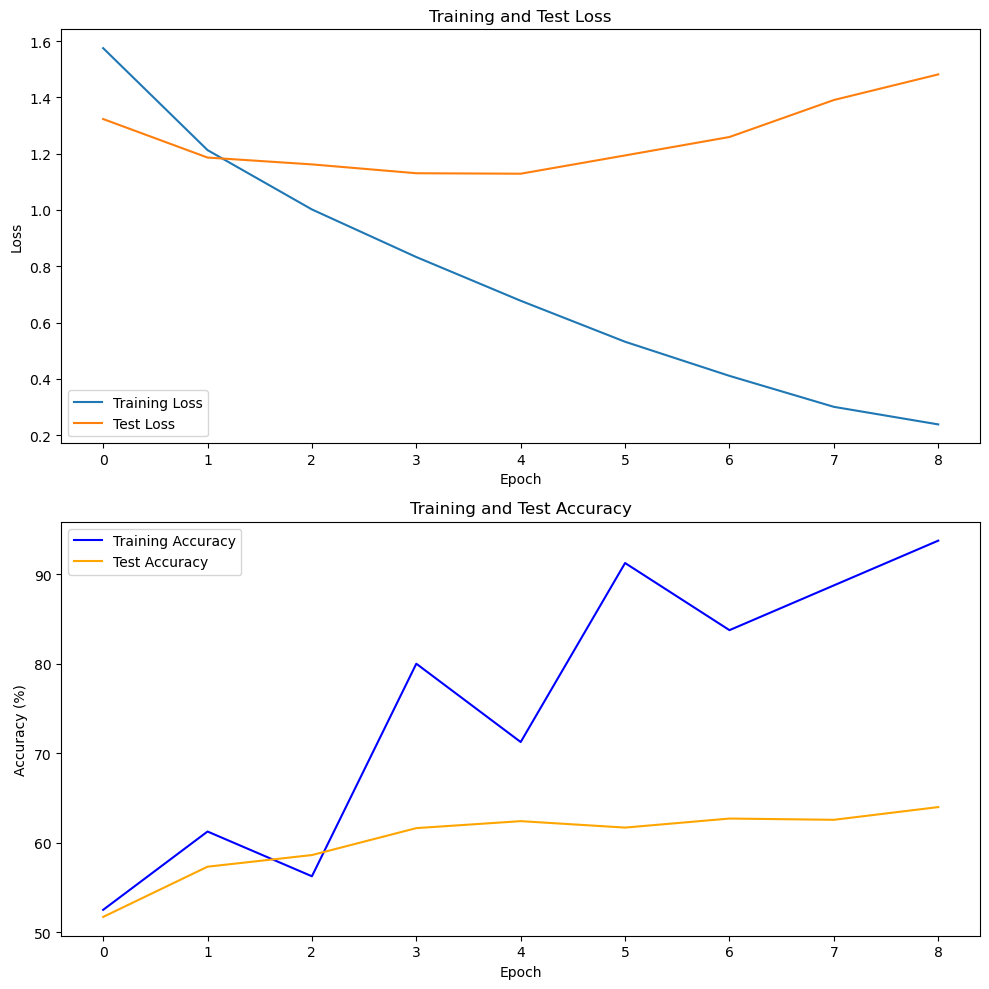

In [30]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label='Training Loss')
axs[0].plot(test_losses, label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color='blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accuracy')

plt.tight_layout()
plt.show()